# Flowers Recognition Dataset

This dataset contains 4242 images of flowers.The data collection is based on the data flicr, google images, yandex images.You can use this datastet to recognize plants from the photo.The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion. For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

## STEP #1: Introduction

This data have 5 different kind flower. These flowers are daisy, dandelion, rose, sunflower and tuilp. I will try recognition them. Firstly i'll the data read then i'll prepare the data. Secondly i'll create my cnn model and train them.

## STEP #2: Import Libraries

In [ ]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
import keras
from keras.models import Sequential, Model
from keras import backend as K
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from sklearn.metrics import classification_report,confusion_matrix
from keras.applications import VGG19
from keras.applications.vgg19 import VGG19, decode_predictions, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import ReduceLROnPlateau

import matplotlib.image as mpimg
from keras import backend as K
import matplotlib.pyplot as plt

# specifically for cnn
from keras.layers import Dense, MaxPool2D
from keras.layers import Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

import cv2
import os
import random
import tensorflow as tf

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

In [ ]:
import os
print(os.listdir('../input/flowers-recognition/flowers'))

## STEP #3: Expoloratory Design Analysis

### 3.1) Reading the Data

In [ ]:
data_dir = "/kaggle/input/flowers-recognition/flowers"
img_size = 150
images_array=[]

Making the functions to get the training and validation set from the Images

In [ ]:
def make_train_data(label, label_index, data_dir):
    path = os.path.join(data_dir, label)
    for img in tqdm(os.listdir(path)):
        try:
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            img_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
            images_array.append([img_arr, label_index])
            data.append(np.array(img_arr))
        except Exception as e:
            print(e)

In [ ]:
data=[]
make_train_data('daisy', 0, data_dir)
print("Daisy Images: " , len(data))
print("Total Images: " , len(images_array))

In [ ]:
data=[]
make_train_data('sunflower', 1, data_dir)
print("Sunflower Images: " , len(data))
print("Total Images: " , len(images_array))

In [ ]:
data=[]
make_train_data('tulip', 2, data_dir)
print("Tulip Images: " , len(data))
print("Total Images: " , len(images_array))

In [ ]:
data=[]
make_train_data('dandelion', 3, data_dir)
print("Dandelion Images: " , len(data))
print("Total Images: " , len(images_array))

In [ ]:
data=[]
make_train_data('rose', 4, data_dir)
print("Rose Images: " , len(data))
print("Total Images: " , len(images_array))

### 3.2) Data Visualization

In [ ]:
flowers_labels = ['daisy','sunflower', 'tulip', 'dandelion', 'rose']
l = []
for i in images_array:
    l.append(flowers_labels[i[1]])
sns.set_style('darkgrid')
sns.countplot(l)

Dataset seems balanced as for each training label

Displaying randomly 25 images

In [ ]:
fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (5):
        l=rn.randint(0,len(images_array))
        ax[i,j].imshow(images_array[l][0])
        ax[i,j].set_title('Flower: '+flowers_labels[images_array[l][1]])
        
plt.tight_layout()

### 3.3) Data Preprocessing

In [ ]:
X = []
Y = []

for feature, label in images_array:
    X.append(feature)
    Y.append(label)

Perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].

In [ ]:
X=np.array(X)
X=X/255

In [ ]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's 
X = X.reshape(-1, img_size, img_size, 3)
Y = np.array(Y)

In [ ]:
label_binarizer = LabelBinarizer()
Y=label_binarizer.fit_transform(Y)

### 3.4) Splitting into Training and Validation Sets

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X , Y , test_size = 0.2 , random_state = 0)

### 3.5) Data Augmentation

In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [ ]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

Randomly rotate some training images by 10 degrees Randomly Zoom by 10% some training images Randomly shift images horizontally by 10% of the width Randomly shift images vertically by 10% of the height..

Once our model is ready, we fit the training dataset .

## STEP #4: Models

### 4.1) Create and Train Initial Model

#### 4.1.1) Create the initial model

Transfer learning refers to using a pretrained model on some other task for your own task. Hence we need to specify the particular model which we are deploying in our task and thus needs to specify the base model.

In our case we are using the VGG19 model from the Keras.Applications library as the base model.

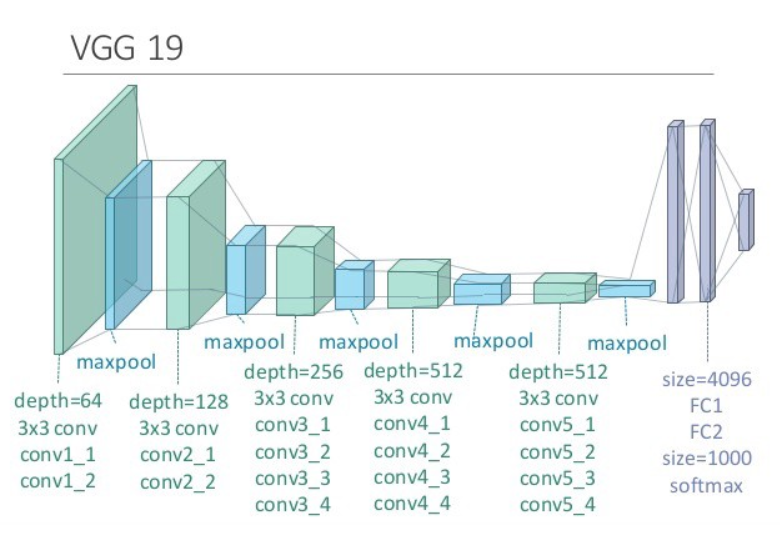

In [ ]:
VGG19_model = VGG19(input_shape=(150,150,3), include_top=False, weights="imagenet")
# setting the VGG model to be untrainable.
VGG19_model.trainable = False
VGG19_model.summary()

Note that this is NOT the summary of our model and this is the summary or the ARCHITECTURE of the VGG19 model that we are deploying as the base model.

#### 4.1.2) Add some Fully Connected Layers

Now we need to add at the top of the base model some fully connected layers. Alsowe can use the BatchNormalization and the Dropout layers as usual in case we want to.

For this I have used a Keras sequential model and build our entire model on top of it; comprising of the VGG model as the base model + our own fully connected layers.

In [ ]:
model = Sequential()
model.add(VGG19_model)
model.add(BatchNormalization())
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(5,activation='softmax'))
model.summary()

This is now the complete summary of our model that we shall use to classify the images.

#### 4.1.3) Learning Rate Annealer

Define the epochs to , and batch size to 128, the learning decay rate

In [ ]:
epochs=50
batch_size=128
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=2, verbose=1)

#### 4.1.4) Compiling & Training the Initial Model

While using transfer learning in ConvNet; we have basically have 3 main approaches

1) To use the pretrained model as a feature extractor and just train your classifier on top of it. In this method we do not tune any weights of the model.

2) Fine Tuning- In this approach we tune the weights of the pretrained model. This can be done by unfreezing the layers that we want to train.In that case these layers will be initialised with their trained weights on imagenet.

3) Lasty we can use a pretrained model.

Note that in this section I have used the first approach ie I have just use the conv layers and added my own fully connected layers on top of VGG model. Thus I have trained a classifier on top of the CNN codes.

In [ ]:
model.compile(optimizer = Adam(lr=1e-4) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = batch_size) , epochs = epochs , 
                    validation_data = (x_test, y_test), verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

#### 4.1.5) Analysis after Initial Model Training

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0] , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

In [ ]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend(['train', 'test'])

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend(['train', 'test'])

plt.show()

### 4.2) Fine Tuning on the initial model (Unfreeze last 5 layers)

#### 4.2.1) Unfreeze the last 5 layers

In this section I have done fine tuning. To see the effect of the fine tuning I have first unfreezed the last block of the VGG19 model and have set it to trainable.

In [ ]:
for i in range (len(VGG19_model.layers)):
    print (i,VGG19_model.layers[i])
  
for layer in VGG19_model.layers[15:]:
    layer.trainable=True
for layer in VGG19_model.layers[0:15]:
    layer.trainable=False

#### 4.2.2) Compiling & Training the Tuned Model

In [ ]:
model.compile(optimizer = Adam(lr=1e-4) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = batch_size) , epochs = epochs , validation_data = (x_test, y_test))

#### 4.2.3) Analysis after Tuned Model Training

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0] , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

Note that the validation accuracy on fine tuning by unfreezing the last block of the VGG19 model has increased to about 82.3% ; almost by 1% as compared to the case when we run a classifier on the top of the CNN codes in previous section

In [ ]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend(['train', 'test'])

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend(['train', 'test'])

plt.show()

### 4.3) Tune the initial model (Unfreeze last 10 layers)

#### 4.3.1) Unfreeze the last 10 layers

Similarly unffreezing the last 2 blocks of the VGG19 model.

In [ ]:
for i in range (len(VGG19_model.layers)):
    print (i,VGG19_model.layers[i])
  
for layer in VGG19_model.layers[11:]:
    layer.trainable=True
for layer in VGG19_model.layers[0:11]:
    layer.trainable=False

#### 4.3.2) Compiling & Training the Tuned Model

In [ ]:
model.compile(optimizer = Adam(lr=1e-4) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = batch_size) , epochs = epochs , validation_data = (x_test, y_test))

#### 4.3.3) Analysis after Tuned Model Training

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0] , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

Note that there is an increase in validation accuracy of about 1% and the same has now reached to about 83.58%.

In [ ]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend(['train', 'test'])

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend(['train', 'test'])

plt.show()

### 4.4) Build the model from scratch (Unfreeze All)

#### 4.4.1) Unfreeze all the layers

Train the model from scratch. Note this is not reasonable though as our data is also not much similar with the imagenet data plus we are quite short of data as we only have around 4200 images.

Hence this model is quite prone to overfitting and I have done this just to check that the results validate with the though-process.

In [ ]:
for layer in VGG19_model.layers:
    layer.trainable=True

#### 4.4.2) Compiling & Training the Tuned Model

In [ ]:
model.compile(optimizer = Adam(lr=1e-4) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = batch_size) , epochs = epochs , validation_data = (x_test, y_test))

#### 4.4.3) Analysis after Tuned Model Training

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0] , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

Decrease the accuracy to 82.2 % with increase in loss

In [ ]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend(['train', 'test'])

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend(['train', 'test'])

plt.show()

Note that the graphs as well as the results clearly show that there is significant overfitting. Also note that despite the overfitting the overall validartion accuracy has though increased from previous best of about 0.815 to a whopping 0.93

### 4.5) Add Fully Connected Layers to the tuned model

#### 4.5.1) Add two Convolution layers and MaxPooling layer 

Keeping the last model (Unfreezing the last two blocks), with adding two convolution layers and MaxPooling layer

In [ ]:
for i in range (len(VGG19_model.layers)):
    print (i,VGG19_model.layers[i])
  
for layer in VGG19_model.layers[15:]:
    layer.trainable=True
for layer in VGG19_model.layers[0:15]:
    layer.trainable=False

In [ ]:
model = Sequential()
model.add(VGG19_model)
model.add(Conv2D(filters=32, kernel_size=(2,2), padding="same", activation="relu"))
model.add(Conv2D(filters=32, kernel_size=(2,2), padding="same", activation="relu"))
model.add(MaxPool2D((2,2) , strides = 2))
model.add(BatchNormalization())
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(5,activation='softmax'))
model.summary()

#### 4.5.2) Compiling & Training the Tuned Model

In [ ]:
model.compile(optimizer = Adam(lr=1e-4) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = batch_size) , epochs = epochs , validation_data = (x_test, y_test))

#### 4.5.3) Analysis after Tuned Model Training

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0] , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

There is a decrease in validation accuracy to about 77.1%.

In [ ]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend(['train', 'test'])

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend(['train', 'test'])

plt.show()

## STEP #5: Save the Model

In [ ]:
import pickle
# Save to file in the current working directory
pkl_filename = "Flowers_Recognition_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)
    
# serialize weights to HDF5
model.save_weights("Flowers_Recognition_model.h5")
print("Saved model to disk")

## STEP #6: Predictons on the Test Set

In [ ]:
predictions = model.predict_classes(x_test)
predictions[:50]

In [ ]:
y_test_inv = label_binarizer.inverse_transform(y_test)

In [ ]:
print(classification_report(y_test_inv, predictions, target_names = flowers_labels))

In [ ]:
cm = confusion_matrix(y_test_inv,predictions)
cm

In [ ]:
cm = pd.DataFrame(cm , index = flowers_labels , columns = flowers_labels)
cm

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = flowers_labels , yticklabels = flowers_labels)

In [ ]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test_inv)):
    if(y_test_inv[i] == predictions[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test_inv)):
    if(y_test_inv[i] != predictions[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

### Correctly Classified Flower Images

In [ ]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+ flowers_labels[predictions[prop_class[count]]] +"\n"+"Actual Flower : "+ flowers_labels[y_test_inv[prop_class[count]]])
        plt.tight_layout()
        count+=1

### UnCorrectly Classified Flower Images

In [ ]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+flowers_labels[predictions[mis_class[count]]]+"\n"+"Actual Flower : "+flowers_labels[y_test_inv[mis_class[count]]])
        plt.tight_layout()
        count+=1

## STEP #7: Class Activation Map (CAM)

In [ ]:
img_path = '../input/flowers-recognition/flowers/sunflower/151898652_b5f1c70b98_n.jpg'
org_img = cv2.imread(img_path)
plt.imshow(org_img)
plt.show()

In [ ]:
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()

In [ ]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x.shape

In [ ]:
x = preprocess_input(x)
x

In [ ]:
model = VGG19(weights='imagenet')
preds = model.predict(x)
cam_predictions = pd.DataFrame(decode_predictions(preds, top=3)[0],columns=['col1','category','probability']).iloc[:,1:]

In [ ]:
argmax = np.argmax(preds[0])
output = model.output[:, argmax]
model.summary()

In [ ]:
last_conv_layer = model.get_layer('block5_conv4')
grads = K.gradients(output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [ ]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [ ]:
import cv2
img = cv2.imread(img_path)

In [ ]:
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
hif = .8
superimposed_img = heatmap * hif + img

In [ ]:
import matplotlib.image as mpimg

output = 'output.jpeg'
cv2.imwrite(output, superimposed_img)
img=mpimg.imread(output)

In [ ]:
plt.imshow(img)
plt.axis('off')
plt.title(predictions[0])

## STEP #8: Conclusion

* Accuracy rate exceeded 80% limit while in the training phase. In the same way validation accuracy return the 80%. I think this is not a bad result for this datasets.
* According to the confusion matrix of the most difficult to detect the type of flower is rose.
* According to the confusion matrix of the easiest to detect the type of flower is sunflower.
* Most false prediction between rose and tuilps.

## STEP #9: References

* https://www.kaggle.com/shivamb/cnn-architectures-vgg-resnet-inception-tl
* https://www.kaggle.com/rajmehra03/a-comprehensive-guide-to-transfer-learning
* https://www.kaggle.com/madz2000/cnn-s-using-vgg16-83-accuracy
* https://github.com/nickbiso/Keras-Class-Activation-Map/blob/master/Class%20Activation%20Map(CAM).ipynb

This kernel would have been imposible to make if not this amazing tutorials: Most basic matplotlib: https://towardsdatascience.com/plt-xxx-or-ax-xxx-that-is-the-question-in-matplotlib-8580acf42f44

Understand the difference between all the methods (add_subplot, add_subplots, add_axes ...): https://towardsdatascience.com/the-many-ways-to-call-axes-in-matplotlib-2667a7b06e06

Matplotlib grid documentation: https://matplotlib.org/tutorials/intermediate/gridspec.html

Great tutorial fore beginners: https://github.com/rougier/matplotlib-tutorial

50 beautiful plots using matplotlib: https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/

Pandas plotting capabilities: https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html**